# Bibliotecas

In [1]:
#Bibliotecas
from shapely import LineString, Point, Polygon
import shapely as sh
import matplotlib.pyplot as plt
from random import uniform
import random as rd
import numpy as np
import scipy
import math as mt

#Para paralelizar
from multiprocessing import Process,Pool
import os
import time
import psutil

#Funciones para paralelizar
import vecindad_paralelo as vp

inicio_programa_tiempo = time.time()

# Funciones

## Funciones auxiliares

Aquí se encuentran las funciones que no tienen procedimientos tan extensos, si no que 
se han hecho para ser llamadas por las funciones principales

In [2]:
#Funciones

def distancia_promedio(zz):
    z = np.array(zz,copy=True)
    distancia = 0
    distancia_promedioA = 0
    for i in range(0,len(zz)-1):
        
            #Calculamos la distancia entre el punto i y el punto j
            #distancia =   Point(z[i,0],z[i,1]).distance(Point(z[i+1,0],z[i+1,1]))
            distancia = ((z[i,0] - z[i+1,0])**2 + (z[i,1] - z[i+1,1])**2)**0.5
            if  distancia != 0:
                distancia_promedioA += distancia
    return distancia_promedioA/(len(zz)-1)

def distancia_de_un_punto_a_otros(zz,punto):
    """
    zz    -> Arreglo numpy de dimensiones(N,2)
    punto -> coordenadas de un punto (x,y)
    """
    
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000
    distancia = 0
    for i in range(0,len(zz)):
        
            #Calculamos la distancia entre el punto i y el punto j
            #distancia =   Point(z[i,0],z[i,1]).distance(Point(punto[0],punto[1]))
            distancia =   ((z[i,0] - punto[0])**2 + (z[i,1] - punto[1])**2)**0.5
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            if distancia_minima>distancia and distancia != 0:
                distancia_minima = distancia

    return distancia_minima

def distancia_de_un_punto_a_otros_condicion(zz,punto,distancia_condicion):
    """
    Si Observa que la distancia minima calculada de un punto a otro punto es
    menor a la distancia condicion parara y regresará False
    En el caso de que no haya ninguna distancia minima menor a la distancia_condicion
    regresará True
    zz    -> Arreglo numpy de dimensiones(N,2)
    punto -> coordenadas de un punto (x,y)
    """
    
    z= np.array(zz)
    
    #Ahora calcularemos las distancias de este punto con los demás
    distancia = 0
    for i in range(0,len(zz)):
        
            #Calculamos la distancia entre el punto i y el punto j
           # distancia =   Point(z[i,0],z[i,1]).distance(Point(punto[0],punto[1]))
            distancia = ((z[i,0] - punto[0])**2 + (z[i,1] - punto[1])**2)**0.5
            #Si la distancia calculada es menor a la distancia condicion parara
            #el proceso y regresará este valor
            if distancia_condicion>distancia and distancia != 0:
                #El punto esta demasiado cerca a otro
                return False
    
    #Si no encontro ningun valor menor a la distancia condicion regresará True
    #el punto esta lo suficientemente a lejado de los demás
    return True



#Funciones

def distancia_de_un_punto_a_otros_identificador(zz,punto):
    """
    zz    -> Arreglo numpy de dimensiones(N,2)
    punto -> coordenadas de un punto (x,y)
    
    Se regresan dos resultados
    distancia_minima -> Float64
    indice -> Indice de cual fue el elemento del arreglo zz
              con el que se encontro la distancia minima
    """
    
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000
    indice = 0
    for i in range(0,len(zz)):
        
            #Calculamos la distancia entre el punto i y el punto j
            #distancia =   Point(z[i,0],z[i,1]).distance(Point(punto[0],punto[1]))
            distancia =   ( (z[i,0] - punto[0]  )**2 + (z[i,1]   - punto[1])**2   )**0.5
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            
            if distancia == 0:
                print("Posible error")
            if distancia_minima>distancia and distancia!=0:
                distancia_minima = distancia
                indice = i

    return distancia_minima, indice


def distancia_minima_todos_puntos(zz,indice_max):
    z= np.array(zz,copy=True)
    #Ahora encontraremos la distancia minima
    distancia_minima = 1000

    for i in range(0,indice_max):
        for j in range(0,indice_max):
            #No se compara la distancia entre puntos iguales
            if i==j:
                continue
            #Calculamos la distancia entre el punto i y el punto j
            distancia = ((z[i,0] - z[j,0])**2 + (z[i,1] - z[j,1])**2)**0.5
            #distancia =   Point(z[i,0],z[i,1]).distance(Point(z[j,0],z[j,1]))
            #Si la distancia calculada es menor a la distancia minima entonces la actualizamos y si 
            #es la primera comparacion esa es la distancia minima
            if distancia_minima>distancia and (distancia != 0):
                distancia_minima = distancia

    return distancia_minima

def identificador_cero(zz):
    z= np.array(zz,copy=True)
    for i in range(0,len(z)):
        if (z[i,0] == 0) and (z[i,1]==0):
            break
    
    return i

#Esta funcion genera las rectas para graficar no para saber que valores tiene esa recta

def f(x,a,b):
    y=0
    xx = np.array(x,copy=True)
    y = a*xx + b
    return y


## Funciones secundarias
Estas funciones tienen como común denominador que:
 -  Tienen uno o varios ciclos en su interior
 -  Son procesos largos que si estuvieran en un solo
     segmento de código se volverían muy dificil de
     darle seguimiento o modificar

### F-> vectores y rectas

In [3]:

#Esta funcion tiene como objetivo calcular las pendientes de multiples rectas 
#en las que cada una pasa sobre dos puntos

def calcular_las_semirectas(arreglo):
    """
    El arreglo que se recibe debe de tener el siguiente formato 
    arreglo :   Dimensiones ->  (ranglones  ,  filas)
                                (N_renglones,2_filas)
                Valores_recibidos ->  [[coord_x, coord_y), (coord_x1,coord_y1),...]
    Se regresará un arreglo con el siguiente formato
    m       :   Dimensiones ->  (ranglones         ,filas)
                                (cantidad_de_Rectas,    6)
                Valores_en_cada_renglon ->   (pendiente, ordenada_origen,
                                                limitex_inferior, limitex_superior
                                                limitey_inferior, limitey_superior)
                
    """
    arreglo_u = np.array(arreglo, copy=True)
    
    #La cantidad de rectas que se van a calcular depende de la cantidad de puntos
    if len(arreglo_u) == 2:
        cantidad_de_rectas = 1
    else:
        cantidad_de_rectas = len(arreglo_u) - 1

        
    rectas = np.zeros((cantidad_de_rectas,6),np.float64)
    
    #Se calcularan las normales 
    for i in range(0,len(rectas)):
        #Hacemos un filtro para comprobar que los puntos 
        #no puedan estar uno sobre otro y no obtendremos un error matematico
        #o un valor gigantesco
        
        #rectas[,0] = np.nan significa que hay infinitos valores y
        #rectas[,0] = np.inf es que hay infinitos valores de x      
        #Caso en el que hay infinitos valores de y para una funcion
        if abs(arreglo_u[i,0] - arreglo_u[i+1,0])<0.000001:
            rectas[i,:] = (np.nan,np.inf,arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
            

            continue
        #Caso en el que hay infinitos valores x para una funcion
        elif abs(arreglo_u[i,1] - arreglo_u[i+1,1])<0.000001:
            rectas[i,:] = (np.inf,np.nan,arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
            continue
            
        #Caso regular
        else:
            p = np.polyfit(
                        arreglo_u[i:i+2,0],
                        arreglo_u[i:i+2,1],
                        1)
            rectas[i,:] = (p[0],p[1],arreglo[i,0],arreglo[i+1,0],arreglo[i,1],arreglo[i+1,1])
        
    return rectas

def vector_director(m1,b1):
    
    #Calculamos dos puntos de cada recta
    x1=1
    x2=2
    P1 = [x1, f(x1,m1,b1)]
    P2 = [x2, f(x2,m1,b1)]
    vector_dire = [P2[0] - P1[0], P2[1] - P1[1]]
    
    #Normalizamos el vector director
    magnitude = (vector_dire[0]**2 + vector_dire[1]**2)**0.5
     
    
    vector_dire = [vector_dire[0]/magnitude, vector_dire[1]/magnitude]
    if np.isinf(m1):
        vector_dire = [1,0]
    elif np.isnan(m1):
        vector_dire = [0,1]
        
    return np.array(vector_dire)


### F-> Puntos en vecindades

In [4]:

def pts_vecindad(arr,pt_c,h):
    """
    Objetivo: El objetivo de la funcion es encontrar todos los puntos (x,y) que se encuentran dentro de 
    una vecindad circular con cierto radio R y regresar los indices correspondientes 
    
    Datos de entrada:
        arr:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
        pt_c:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
        h:
            Variable tipo flotante
    Datos de salida:
        indices_arr:
            Arreglo tipo numpy con tipo de dato np.float64
            Dimensiones   ->    (renglones,columnas)
                                (        M,       1)
                                M es la canatidad de indices que la funcion encuentre
                                dentro de la vecindad
    nota: Se espera que una futura implementación permita tambien reducir la cantidad de calculos
          tomando encuenta que un pt1 ya se encuentra en la vecindad de otro pt2, por lo que pt2
          es parte de la vecindad de pt1
          
    """
    arr_u = np.array(arr,copy=True)
    N = len(arr_u)
    
    indices_arr = np.zeros((N,1),np.float64)
    
    #Cuenta cuantos pts caen dentro de la vecindad
    cont_in_h = 0
    
    
    for i in range(0,N):
        
        #Observamos que no haya dos puntos iguales mas de dos veces, por que si hay dos puntos iguales
        #mas de dos veces tenemos un error en nuestro filtrado de puntos en el poligono
        
        
        #Observamos si la distancia entre los puntos pt_c, y arr_u[i] es menor que
        #el radio de la vecindad y 
        distance = Point(pt_c[0],pt_c[1]).distance(Point(arr_u[i,0],arr_u[i,1]))
        print("usamos esta funcion")
        if (h > distance) and (distance!=0.0):
            #Si es menor entonces guardamos el indice y aumentamos el contador
            indices_arr[cont_in_h,0] = i
            cont_in_h +=1
        elif distance==0.0:
            continue
            
    #Regresamos un indice con esos datos y solo esos datos
    return indices_arr[:cont_in_h]



#### F->Paralelizacion

In [5]:
"""
Esta funcion debe de estar guardada en un archivo .py aparte para ser llamada cuando la requiramos
def vecindad_paralelo_proceso(h,N_f,pts_vec,pt_g_u):    
    return
"""

def vecindad_paralelo_estructura(h,pt_g_u):
    """
    El objetivo de la funcion es mandar varios puntos al mismo tiempo para encontrar sus respectivas vecindades
    
    """
    #Calculamos la cantidad de nucleos que tenemos disponibles
    cores = os.cpu_count()  
    
    #Este for se encargara de dividir los datos de pt_g_u en una lista para poder pasarlos a la
    #funcion map
    
    #Tenemos la varibale en donde se guardaran los argumentos que pasaremos
    lista = []
    
    #Lo que nos dará la pauta de en cuanto dividiremos el arreglo
    N = round(len(pt_g_u)/cores)
    Nf = 0
    Ni = 0
    
    #Se empiezan a guardar los datos que queremos 
    
    """
    Lo que se hace es que se pasan los argumentos que pasaremos a cada funcion
    en cada core en forma de lista, tal que:
        h es la distancia a la que buscaremos la vecindad de los puntos
        Ni,Nf representaran el slice de elementos que son los
              puntos a los que se les buscarán sus vecindades en ese core
        pt_g_u solamente es el arreglo de puntos con los que se comparara su distancia a cada 
                punto central en cada core
    """
    for i in range(0,cores):
        Ni= i*N 
        Nf= (i+1)*N
        if i==(cores-1):
            Nf = len(pt_g_u)
        lista.append((h,Ni,Nf,pt_g_u))
    #Se hace el procesado paralelizado
    if __name__=='__main__':
        """
        Pool(processes=cores) -> Nos dice cuantos procesos se van a crear
                                 y si son menos de los que se aplican en .map()
                                 se van a poner en cola hasta que acaben los otros
        """
        with Pool(processes=cores) as p:
            m = p.starmap(vp.vecindad_paralelo_proceso,lista)

    return m


### F-> Normales por optimizacion

In [6]:

def C_matrix_normal(sum_M,arr_u,pt_c_u,f,h):
    """
    Objetivo: Llevar acabo la suma de matrices dada por la ecuacion
    #La ecuacion que generara cada una de las matrices es
    #    ----
    #    \   (r_j - r_i)(r_j - r_i)^T
    # C = -    ---------------------    w_(i,j)
    #    /       ||r_j - r_i||^2
    #    ----
    #      j
    # Donde las r_j representa a todos los puntos circundantes
    # y la sumatoria va rondando en ellos, no se calcula a si mismo
    
    y regresar solo la suma de todas las matrices generadas
    
        Datos de entrada:
        sum_M:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    donde se guardara la suma de matrices               
        
        arr_u:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
            objetivo      ->    donde se guardaran los puntos (x,y) circundantes
                                al punto central, así que estos deben ser filtrados 
                                con anterioridad a la función.
                                Un punto (x,y) por cada renglon
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
            objetivo      ->    donde se guardaran las coordenadas (x,y)
                                del punto central en el que se estan llevando acabo
                                las operaciones para encontrar su normal
        f:
            String
            Opciones permitidas: "Gaussian","Inverse","Polynomal","Identity","Laplacian","Cousine"
            objetivo      ->    Decir que función de peso se usará para
                                calcular cada una de las matrices que se sumara
        h:
            Int
            Objetivo:     ->    Establecer la vecindad en la que se tomaran en cuenta
                                el peso de los puntos para calcular la matrix
        
    Dato de salida:
        sum_M:
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            objetivo      ->    Ser ya la suma de todas las matrices que calculamos
    """
    #Lo del vector transpuesto no funciona como deberia aveces, así que hay
    #que asegurarse o hacer una funcion especifica aparte, para generar la matrix
    # de 2x2
    dif_ij = np.zeros((1,2),np.float64)
   
    
    #Eleccion de funcion de peso
    h=1
    if f == "Gaussian":
        f = "(1/(delta*(2*np.pi)**0.5))*np.exp(-((magnitude2**0.5)-promedio)**2/(2*delta**2))"
    
    """
    Vamos a calcular la delta que es la des estandar, para eso:
    1 primero encontraremos todas las disntancias
      entre nuestro punto y los demas
    
    2 Sacamos la desviacion estandar con una funcion de numpy
    """
    #Variable para tener todas las magnitudes 
    mag_arr = np.zeros((len(arr_u),1),np.float64)
    #Identificador del indice que nos da el punto que sera igual
    identificador = 0
    
    #Arreglo que calculara la diferencia de posiciones
    #entre los vectores y nuestro pt
    for i in range(0,len(arr_u)):
        if (arr_u[i,0]==pt_c_u[0]) and (arr_u[i,1]==pt_c_u[1]):
            identificador = i
            continue
        dif_ij = arr_u[i,:] - pt_c_u
        mag_arr[i] = ((dif_ij[0])**2+(dif_ij[1])**2)**0.5
    
    #Eliminamos el que no tiene nada por que seria la distancia
    #consigo mismo
    mag_arr = np.delete(mag_arr,(identificador),axis=0)
    
    #Calculamos la delta
    delta = np.std(mag_arr)
    promedio = np.mean(mag_arr)
    #Por como guardamos los puntos la transpuesta es la normal y viceversa
    #pero se sigue el mismo procedimiento descrito arriba
    for j in range(0,len(arr_u)):
        
        #La siguiente condicion se asegura de que no se saque la diferencia
        #de vectores, siendo ambos vectores los mismos
        if (arr_u[j,0]==pt_c_u[0]) and (arr_u[j,1]==pt_c_u[1]):
            continue
        
        
        #Se saca la diferencia entre vectores posicion
        dif_ij = arr_u[j,:] - pt_c_u
        #Se saca la magnitud de la diferencia entre los vec_posicion
        magnitude2 = ((dif_ij[0])**2+(dif_ij[1])**2)
        
        #Si la magnitud es más grande que cierto valor el peso es 0
        if magnitude2>h:
            continue
        
        #Se suma a la matriz resultante la nueva matriz
        elemento_00 = dif_ij[0]**2
        elemento_11 = dif_ij[1]**2
        elemento_01_10 = dif_ij[0]*dif_ij[1]
        f_eval = eval(f)
        sum_M[0,0] +=  ((elemento_00)/(magnitude2))*f_eval
        sum_M[1,1] +=  ((elemento_11)/(magnitude2))*f_eval
        sum_M[0,1] +=  ((elemento_01_10)/(magnitude2))*f_eval
        sum_M[1,0] +=  ((elemento_01_10)/(magnitude2))*f_eval
        

        #sum_M +=  ((np.transpose(dif_ij)*dif_ij)/(magnitude2))*f_eval
        
    return sum_M

def C_eigen_ponderado(sum_M,pt_c_u,Figura):
    """
    C_eigen_normal donde calcularemos los eigenvalores e eigenvectores 
    y obtendremos el eigenvalor minimo y su eigenvector correspondiente 
    que debe ser el normal
    """
    """
    Objetivo_General:
    
    C_eigen_ponderado donde aparte de obtener los eigenvalores e eigenvectores, 
    veremos que estos no esten apuntando dentro de la figura, si lo estan
    modificamos su direccion por un factor -1.  Despues tomamos ambos eigenvectores 
    y según su eigenvalor ponderamos un vector promedio ponderado 
    y ese será el vector normal al punto
    
    Datos de entrada:
        sum_M:
            Arreglo tipo numpy 
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    Que se le de una matriz 2x2
                                con diferentes valores
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2) 
            Objetivo      ->    Tener como referencia a que punto correspondera
                                el eigevector con el eigenvector minimo
        Figura:
            Classe tipo Polygon
            Objetivo      ->    Saber si los eigenvectores apuntan para 
                                afuera o para adentro
    Datos de salida:
        normal_vec_: eig_1 or eig_2
            Dimensiones    ->    (renglones,columnas)
                                 (       1,        2)
            Objetivo       ->    Saber la direccion a la que apunta 
                                 la normal obtenida
                                 
        pt_c_u:
            Solo saber a que punto pertenece y así tener más control de la funcion
            que estamos aplicando, en un futuro puede ser eliminado, todo depende de la
            implementacion de otras funciones
     """
    
    #Con la matriz 2x2 recibida solo tenemos que  encontrar sus eigenvalores e eigenfunciones
    Eigen_data = np.linalg.eig(sum_M)
    
    #Esta solo encuentra los eigenvalores para comprobar
    R_v = scipy.linalg.eigvals(sum_M)
    
    #Renombramos el arreglo para hacer un mejor manejo de los datos
    R = Eigen_data
    #Ahora sacamos los eigenvectores a la forma en que nosotros estamos
    #guardando un vector desde el principio
    #Eigenvectores
    
    #Queremos reconocer que indice de eigenvalor corresponde
    #a q indice de eigenvector y como solo ex una matriz de 2x2
    #si un eigenvalor no corresponde a eig_vec 1 corresponde al dos
    #así de simple
    eig_1 = np.array([R[1][0][0],R[1][1][0]])
    eig_2 = np.array([R[1][0][1],R[1][1][1]])
    #print(eig_1)
    #Con el siguiente código se comprueba que eigenvalor esta
    #asocidado a cada eigenvector con la ecuacion de eigenvalores y eigenvectores
    # R_v[0]*n = sum_M*n ----------------------------------------------------------------------------------[ec1]
    
    #En las siguientes variables se guardara la multiplicacion
    #de la matrix con el eigenvector correspondiente
    x=0
    y=0
    z=0
    for i in range(0,2):
        x += sum_M[0][i]*eig_1[i]
        y += sum_M[1][i]*eig_1[i]
    
    #Ahora elegimos el eigenvalor más pequeño que es el que queremos
    #encontrar y según cual sea regresaremos el eigenvector correspondiente
    # y el punto 

    
    #Esta variable guardara el menor valor de una sola vez para
    #poder ya trabajar con el eigenvalor menor
    eig_valor = R_v[1]*(R_v[0]>R_v[1]) + R_v[0]*(R_v[1]>R_v[0])
            
    #Creamos la derecha e izquierada de la ec1
    izq_ecuacion = np.around((eig_valor*np.array(eig_1)).real,5)
    der_ecuacion = np.round(np.array([x,y]),5)

    #Si son iguales regresaremos ese eigen_vector, pero
    #ya puesto para que apunte fuera de la figura y si no
    #regresamos el otro
    if (der_ecuacion == izq_ecuacion).all() == True:
        
        #Obtenemos el eigenvector_ponderado
        eig_pon = (eig_1*abs(eig_valor) + eig_2*abs((R_v[1]*(R_v[0]<R_v[1]) + R_v[0]*(R_v[1]<R_v[0])))/(R_v[0]+R_v[1]))
        eig_pon = eig_pon/(eig_pon[0]**2 + eig_pon[1]**2 )**0.5 
        #Comprobación de si apunta dentro o fuera
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        
        x_final =float( eig_pon[0]*0.001 + pt_c_u[0])
        y_final =float( eig_pon[1]*0.001 + pt_c_u[1])
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            eig_pon *=-1
            
        return eig_pon,pt_c_u
    else:
       
        eig_pon = (eig_2*abs(eig_valor) + eig_1*abs((R_v[1]*(R_v[0]<R_v[1]) + R_v[0]*(R_v[1]<R_v[0])))/(R_v[0]+R_v[1]))
        eig_pon = eig_pon/(eig_pon[0]**2 + eig_pon[1]**2 )**0.5   
        #print(eig_valor)
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        x_final = float(eig_pon[0]*0.001 + pt_c_u[0])
        y_final = float(eig_pon[1]*0.001 + pt_c_u[1])
             
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            #print("antes",eig_2)
            eig_pon = eig_pon*-1
            #print(eig_2)
            #print("Eigens:",eig_2,"   ",eig_1)
            
            return eig_pon,pt_c_u
        
        return eig_pon,pt_c_u
    
    
    print("FALLLO CRITICO LA FUNCION NO HA CUMPLIDO EL OBJETIVO")
    return None
    pass

def C_eigen_normal(sum_M,pt_c_u,Figura):
    """
    Objetivo_General:
    
    C_eigen_ponderado donde aparte de obtener los eigenvalores e eigenvectores, 
    veremos que estos no esten apuntando dentro de la figura, si lo estan
    modificamos su direccion por un factor -1.  Despues tomamos ambos eigenvectores 
    y según su eigenvalor ponderamos un vector promedio ponderado 
    y ese será el vector normal al punto
    
    Datos de entrada:
        sum_M:
            Arreglo tipo numpy 
            Dimensiones   ->    (renglones,columnas)
                                (        2,       2)
            Objetivo      ->    Que se le de una matriz 2x2
                                con diferentes valores
        pt_c_u:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2) 
            Objetivo      ->    Tener como referencia a que punto correspondera
                                el eigevector con el eigenvector minimo
        Figura:
            Classe tipo Polygon
            Objetivo      ->    Saber si los eigenvectores apuntan para 
                                afuera o para adentro
    Datos de salida:
        normal_vec_: eig_1 or eig_2
            Dimensiones    ->    (renglones,columnas)
                                 (       1,        2)
            Objetivo       ->    Saber la direccion a la que apunta 
                                 la normal obtenida
                                 
        pt_c_u:
            Solo saber a que punto pertenece y así tener más control de la funcion
            que estamos aplicando, en un futuro puede ser eliminado, todo depende de la
            implementacion de otras funciones
     """
    #print("Normal")
    #Con la matriz 2x2 recibida solo tenemos que  encontrar sus eigenvalores e eigenfunciones
    Eigen_data = np.linalg.eig(sum_M)
    
    #Esta solo encuentra los eigenvalores para comprobar
    R_v = scipy.linalg.eigvals(sum_M)
    
    #Renombramos el arreglo para hacer un mejor manejo de los datos
    R = Eigen_data
    #Ahora sacamos los eigenvectores a la forma en que nosotros estamos
    #guardando un vector desde el principio
    #Eigenvectores
    
    #Queremos reconocer que indice de eigenvalor corresponde
    #a q indice de eigenvector y como solo ex una matriz de 2x2
    #si un eigenvalor no corresponde a eig_vec 1 corresponde al dos
    #así de simple
    eig_1 = np.array([R[1][0][0],R[1][1][0]])
    eig_2 = np.array([R[1][0][1],R[1][1][1]])
    #print(eig_1)
    #Con el siguiente código se comprueba que eigenvalor esta
    #asocidado a cada eigenvector con la ecuacion de eigenvalores y eigenvectores
    # R_v[0]*n = sum_M*n ----------------------------------------------------------------------------------[ec1]
    
    #En las siguientes variables se guardara la multiplicacion
    #de la matrix con el eigenvector correspondiente
    x=0
    y=0
    z=0
    for i in range(0,2):
        x += sum_M[0][i]*eig_1[i]
        y += sum_M[1][i]*eig_1[i]
    
    #Ahora elegimos el eigenvalor más pequeño que es el que queremos
    #encontrar y según cual sea regresaremos el eigenvector correspondiente
    # y el punto 

    
    #Esta variable guardara el menor valor de una sola vez para
    #poder ya trabajar con el eigenvalor menor
    eig_valor = R_v[1]*(R_v[0]>R_v[1]) + R_v[0]*(R_v[1]>R_v[0])
    #print(eig_valor)
    #Creamos la derecha e izquierada de la ec1
    izq_ecuacion = np.around((eig_valor*np.array(eig_1)).real,5)
    der_ecuacion = np.round(np.array([x,y]),5)

    #Si son iguales regresaremos ese eigen_vector, pero
    #ya puesto para que apunte fuera de la figura y si no
    #regresamos el otro
    if (der_ecuacion == izq_ecuacion).all() == True:
        #print(eig_valor)    
        #Comprobación de si apunta dentro o fuera
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        x_final = eig_1[0]*0.001 + pt_c_u[0]
        y_final = eig_1[1]*0.001 + pt_c_u[1]
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            eig_1 *=-1
            
        return eig_1,pt_c_u
    else:
        
        #Para la comprobacion si esta dentro o fuera hay que calcular
        #apartir del punto al que sera normal
        
        x_final = eig_2[0]*0.001 + pt_c_u[0]
        y_final = eig_2[1]*0.001 + pt_c_u[1]
              
        
        #Si esta fuera entonces hay que voltear la direccion del eigenvector
        if (sh.contains(poly,Point(x_final,y_final))) == True:
            #print("antes",eig_2)
            eig_2 = eig_2*-1

            return eig_2,pt_c_u
        
        return eig_2,pt_c_u
    
    
    print("FALLLO CRITICO LA FUNCION NO HA CUMPLIDO EL OBJETIVO")
    return None
    

def normal_metodo_optimizacion(pts_nhd,pt_c,f,Figura,metodo,h):
    """
    Objetivo: Se busca poder calcular la normal de los puntos de un poligono
    por medio del metodo de optimizacion presentado en el articulo
    del profesor Félix
    
    Datos de entrada:
        arr:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                N es un numero entero deseado
        pt_c:
            Arreglo tipo numpy o lista, preferiblemente un arreglo
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
        f:
            String
            Opciones permitidas: "Gaussian","Inverse","Polynomal","Identity","Laplacian","Cousine"
        
        Figura:
            Classe Polygon 
            Objetivo       -> Ayudarnos a saber que el eigenvector que sera el normal
                              apunta hacia afuera
        h:
            Int
            Objetivo:     ->    Establecer la vecindad en la que se tomaran en cuenta
    Dato de salida:
        Normal:
            Dimensiones   ->    (renglones,columnas)
                               (        1,       4)
            Se busca que este dato sea el vector normal al punto ya normalizado (x1,y1,x2,y2)
            donde x1,y1 representen donde inicia y x2y2 donde termina
    """
    #Como podriamos modificar los valores, no queremos que haya problemas
    arr_u = np.array(pts_nhd, copy=True)
    pt_c_u =  np.array(pt_c, copy=True)
#     
    #Aquí guardaremos la suma de todas las matrices generadas
    sum_M =np.zeros((2,2),np.float64)
    
    #Aqui guardaremos la magnitud al cuadrado de la diferencia entre los vectores
    magnitude2 = 0
    
    #Aqui guardaremos el vector diferencia transpuesto
    
    #Lo del vector transpuesto no funciona como deberia aveces, así que hay
    #que asegurarse o hacer una funcion especifica aparte, para generar la matrix
    # de 2x2
    dif_ij = np.zeros((1,2),np.float64)
    
    #La ecuacion que generara cada una de las matrices es
    #    ----
    #    \   (r_j - r_i)(r_j - r_i)^T
    # C = -    ---------------------    w_(i,j)
    #    /       ||r_j - r_i||^2
    #    ----
    #      j
    # Donde las r_j representa a todos los puntos circundantes
    # y la sumatoria va rondando en ellos, no se calcula a si mismo
    
    sum_M = C_matrix_normal(sum_M,arr_u,pt_c_u,f,h)
    
    #Ahora sacamos el eigenvector util y elegimos el metodo que queremos
    
    if metodo == 0:
        Eigen_data_data = C_eigen_normal(sum_M,pt_c_u,Figura)
    elif metodo == 1:
        Eigen_data_data = C_eigen_ponderado(sum_M,pt_c_u,Figura)
    #print(Eigen_data_data)
    #Ya con el eigenvector normal ya devolvemos la informacion que queremos
    return Eigen_data_data[0]

# Figura

Lo que buscamos aquí es ordenar los puntos de la siguiente forma:

    - Dar un arreglo
    - Generar un arreglo vacio de las mismas dimensiones
    - Elegir un elemento de ese arreglo
    - Guardar ese elemento en la primera parte del arreglo en ceros
    - Calcular cual es el siguiente punto más cercano a ese
    - Guardar ese punto en el siguiente indice del arreglo en ceros
    - Eliminar el punto del arreglo original

Posible error


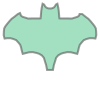

In [7]:
Puntos_sin_ordenar = [(0.398800723842904, -7.95365259525281), (3.68659254979499, -5.78561595640035), (0.517923616087545, -7.31038897713175), (0.684695665230042, -6.78624825125533), (0.827643135923611, -6.30975668227677), (1.11353807731075, -5.97621258399178), (1.49473133249360, -5.76179137795142), (1.87592458767645, -5.64266848570678), (2.35241615665501, -5.54737017191107), (2.85273230408251, -5.57119475036000), (3.23392555926536, -5.66649306415571), (3.80571544203963, -5.38059812276857), (3.90101375583535, -4.95175571068787), (4.02013664807999, -4.57056245550502), (4.28220701101820, -4.23701835722002), (4.56810195240534, -3.92729883738396), (4.90164605069033, -3.78435136669039), (5.33048846277104, -3.66522847444575), (5.78315545330067, -3.66522847444575), (6.14052413003459, -3.71287763134360), (6.25964702227924, -3.26021064081397), (6.23582244383031, -2.68842075803969), (6.18817328693245, -2.33105208130577), (6.00000000000000, -2.00000000000000), (5.71168171795389, -1.64013930628686), (5.47343593346461, -1.35424436489972), (5.18754099207747, -1.04452484506365), (4.83017231534355, -0.782454482125443), (4.35368074636498, -0.401261226942592), (4.05994439664004, -0.188418145184806), (3.99831611752934, -0.393845742220471), (3.94695921827042, -0.578730579552571), (3.81343128019724, -0.712258517625753), (3.66963196227227, -0.784158176588236), (3.42311884582947, -0.866329215402503), (3.22796262864559, -0.917686114661419), (3.00000000000000, -1.00000000000000), (2.76575053531534, -1.01012853332747), (2.53978017857610, -0.999857153475685), (2.28299568228152, -0.999857153475685), (2.00000000000000, -1.00000000000000), (1.70779841058166, -0.999857153475685), (1.46128529413886, -0.999857153475685), (1.27640045680676, -0.979314393772119), (1.24558631725141, -0.763615416884670), (1.23531493739962, -0.558187819849004), (1.20450079784427, -0.280860563850855), (1.18395803814071, 0.00000000000000), (1.15314389858536, 0.201894289182960), (1.13260113888179, 0.386779126515059), (1.09151561947466, 0.592206723550725), (1.04015872021574, 0.818177080289957), (1.00000000000000, 1.00000000000000), (0.845002503031856, 0.920890878807790), (0.742288704514023, 0.797634320586390), (0.660117665699756, 0.633292242957858), (0.516318347774790, 0.489492925032892), (0.351976270146257, 0.407321886218625), (0.177362812665940, 0.355964986959709), (-0.398800723842905, -7.95365259525281), (-3.68659254979499, -5.78561595640035), (-0.517923616087546, -7.31038897713175), (-0.684695665230043, -6.78624825125533), (-0.827643135923612, -6.30975668227677), (-1.11353807731075, -5.97621258399178), (-1.49473133249360, -5.76179137795142), (-1.87592458767645, -5.64266848570678), (-2.35241615665502, -5.54737017191107), (-2.85273230408251, -5.57119475036000), (-3.23392555926536, -5.66649306415571), (-3.80571544203963, -5.38059812276857), (-3.90101375583535, -4.95175571068787), (-4.02013664807999, -4.57056245550502), (-4.28220701101820, -4.23701835722002), (-4.56810195240534, -3.92729883738396), (-4.90164605069033, -3.78435136669039), (-5.33048846277104, -3.66522847444575), (-5.78315545330067, -3.66522847444575), (-6.14052413003460, -3.71287763134360), (-6.25964702227924, -3.26021064081397), (-6.23582244383031, -2.68842075803969), (-6.18817328693245, -2.33105208130577), (-6.00000000000000, -2.00000000000000), (-5.71168171795389, -1.64013930628685), (-5.47343593346461, -1.35424436489972), (-5.18754099207747, -1.04452484506365), (-4.83017231534355, -0.782454482125442), (-4.35368074636498, -0.401261226942592), (-4.05994439664004, -0.258418145184805), (-3.99831611752934, -0.393845742220471), (-3.94695921827042, -0.578730579552570), (-3.81343128019724, -0.712258517625753), (-3.66963196227227, -0.784158176588236), (-3.42311884582947, -0.866329215402502), (-3.22796262864559, -0.917686114661419), (-3.00000000000000, -1.00000000000000), (-2.76575053531534, -1.01012853332747), (-2.53978017857610, -0.999857153475685), (-2.28299568228152, -0.999857153475685), (-2.00000000000000, -1.00000000000000), (-1.70779841058166, -0.999857153475685), (-1.46128529413886, -0.999857153475685), (-1.27640045680676, -0.979314393772119), (-1.24558631725141, -0.763615416884670), (-1.23531493739962, -0.558187819849004), (-1.20450079784427, -0.280860563850855), (-1.18395803814071, 1.44993042173379E-16), (-1.15314389858536, 0.201894289182960), (-1.13260113888179, 0.386779126515059), (-1.09151561947466, 0.592206723550725), (-1.04015872021574, 0.818177080289957), (-1.00000000000000, 1.00000000000000), (-0.845002503031856, 0.920890878807790), (-0.742288704514023, 0.797634320586391), (-0.660117665699756, 0.633292242957858), (-0.516318347774790, 0.489492925032892), (-0.351976270146256, 0.407321886218625), (-0.177362812665940, 0.355964986959709)]
 
Puntos_sin_ordenar = np.array(Puntos_sin_ordenar)
Puntos_ordenados = np.zeros((len(Puntos_sin_ordenar),len(Puntos_sin_ordenar[0,:])), np.float64)

#Elemento inicial 
ele = 0
Puntos_ordenados[0,:] = Puntos_sin_ordenar[ele,:]

#Aqui se guardará el indice de con que otro punto se consiguio la distancia minima
identificador = 0
#distancia_minima
for i in range(0,len(Puntos_sin_ordenar)-1):

        distancia_minima,identificador = distancia_de_un_punto_a_otros_identificador(Puntos_sin_ordenar,Puntos_ordenados[i,:])
        
        Puntos_ordenados[i+1,:] = Puntos_sin_ordenar[identificador,:]

        Puntos_sin_ordenar = np.delete(Puntos_sin_ordenar,(identificador),axis=0)

#Eliminamos el primer punto repetido
Puntos_ordenados = np.delete(Puntos_ordenados,0,axis=0)

poly = Polygon(Puntos_ordenados)
Figura = Puntos_ordenados

""""
#Así se recuperan los puntos
#mmm= poly.exterior.coords.xy
#Y asi esta el primer punto x,y
#print(mmm[0][0],mmm[1][0])
poly = poly.simplify(0.1)

data = poly.exterior.coords.xy
ext_data = len(data[0])
Figura = np.zeros((ext_data,2),np.float64)

for i in range(0,ext_data):
    Figura[i,:] = data[0][i],data[1][i]
print(ext_data)
"""
poly


In [8]:
#Comparemos si hay un punto repetido
for i in range(0,len(Puntos_ordenados)-1):
    if (Puntos_ordenados[i,0] ==Puntos_ordenados[i+1,0]) and (Puntos_ordenados[i,1] ==Puntos_ordenados[i+1,1]):
        print("Punto repetido")
        


# Estructuras de datos

In [9]:
#Numero de puntos iniciales
N = len(Figura)

#Numero de contornos
cant_de_contornos = 1

#Requerimos un aproximado de los puntos totales que queremos en la figura
repeticion = 10
N_aprox = N + N*repeticion


In [10]:

contornos_tipo = np.dtype([
        ('pt_f_c',np.float64,(N_aprox,2)),
        ('Color',np.int64,(N_aprox,)),
        ('Contorno',np.int64),
        ('pt_vec',np.float64,())
])




"""
Así genero un arreglo con este tipo de estructura de datos
"""
#contornos = np.zeros((cant_de_contornos),dtype=contornos_tipo)
#contornos[0]['Color'][0] = 's'

'\nAsí genero un arreglo con este tipo de estructura de datos\n'

# Programa general

In [11]:
#Aquí guardaremos la coordenada (x,y) del punto aleatorio generado
pt_ale = [0,0]

#Arreglo en donde estaran todos estos puntos con sus caracteristicas
#Puntos generales
pts_g = np.zeros((cant_de_contornos),dtype=contornos_tipo)

#Como acceder a un punto de la estructura de datos
#pts_g[0]['pt_f_c'][0,:]

#Arreglo para animar
pt_f_c_x_animation = np.zeros((N_aprox,N_aprox),np.float64)
pt_f_c_y_animation = np.zeros((N_aprox,N_aprox),np.float64)

#Variable para la distancia minima entre puntos
distancia_minima = 1000

#Guardamos los puntos de la figura en el arreglo
pts_g[0]['pt_f_c'][:len(Figura),:] = Figura[:,:]
#Le damos el color a los puntos del contorno que sera identificado con el 0
pts_g[0]['Color'][:len(Figura)] = 0

#Calcularemos las pendientes de todo
rectas = calcular_las_semirectas(pts_g[0]['pt_f_c'][:N])

#Ahora que ya calculamos las rectas para todos los puntos
#toca encontrar la recta normal a cada una de ellas
rectas_normales = np.array(rectas,copy=True)
for i in range(0,len(rectas)):
    #rectas[,0] = np.nan significa que hay infinitos valores y
    #Rectas[,0] = np.inf es que hay infinitos valores de x    
    
    #Condicion 
    #Si una recta tiene inf valores de Y, entonces la normal
    #tiene inf valores de X para una sola Y
    if np.isnan(rectas[i,0])==True:
        rectas_normales[i,0] = np.inf
        rectas_normales[i,1] = np.nan

    elif np.isinf(rectas[i,0])==True:
        rectas_normales[i,0] = np.nan
        rectas_normales[i,1] = np.inf

    else:
        rectas_normales[i,0] = -1*(1/rectas[i,0])


#Ahora pasara por el punto deseado en teoria
nueva_b = np.zeros((len(rectas),1),np.float64)
nueva_b_derechos = np.zeros((len(rectas),1),np.float64)

#y Ahora calculamos los vectores normales de cada recta normal
#Aqui guardamos los vectores normales
vec_normal = np.zeros((len(rectas),2),np.float64)

for i in range(0,len(rectas)):
    #CALCULAMOS nueva B para que las rectas pasen por los puntos izquierdos
    nueva_b[i] = (rectas[i,3] - rectas_normales[i,0]*rectas[i,2]) 
    
    #Calculamos nuevos vectores normales promedio
    vec_normal[i,:] = vector_director(rectas_normales[i,0],rectas_normales[i,1])

    


#Calculamos la distancia minima entre todos los puntos
distancia_minima = distancia_minima_todos_puntos(pts_g[0]['pt_f_c'][:N,:],N) 

#Definimos los radios interior y exterior
r_interior = distancia_minima
r_exterior = distancia_promedio(pts_g[0]['pt_f_c'][:N,:])

print(r_exterior)

#Nos permite saber que tanto mover indices segun puntos aleatorios generados
cant_pt_cumplidos =0

#Contador de nuevos puntos
i=int(0)

#Contador para saber si ya fueron muchos intentos
intentos_limites = 50
contador_intentos = 0

#Contador de nuevos calculos completos
cont_elementos=N


#Numero de elementos que tiene el frente de avance
frente_n_elementos = N


#Finalizado_condicion?
finalizado = 0
tiempo_inicial = time.time()
#Este for generara puntos hasta llegar a la iteracion que
#buscamos
while i<(N_aprox-N):
    
    """
    #Esta parte identificara si hay todavia elementos iguales a cero y permitira
    #calcular nuevos elementos
    if i>identificador_cero(pts_g[0]['pt_f_c']):
        i = identificador_cero(pts_g[0]['pt_f_c']) - 5*cont_completos
        if i<N or cont_completos==8:
            i = 0
        print(cont_completos)
        cont_completos +=1
    if cont_completos>9 or :
        break
    """
    #Esto va cambiando el frente de onda para solo generar nuevos puntos
    #en los puntos ya generados con anterioridad
    if frente_n_elementos == i:
        i = frente_n_elementos
        frente_n_elementos = N + cant_pt_cumplidos
        #print("i",i," frente",frente_n_elementos)
    if i ==frente_n_elementos:
        #print("a")
        finalizado+=1
        i=0
    if finalizado >4:
        break
    while True:
            #print(i)
            #Se genera un punto aleatorio alrededor del punto que
            #que buscamos en una cuadratura
            argu_rd = 2*mt.pi*rd.random()
            pt_ale[0] = (r_exterior*mt.cos(argu_rd) + pts_g[0]['pt_f_c'][i,0])
            pt_ale[1] = (r_exterior*mt.sin(argu_rd) + pts_g[0]['pt_f_c'][i,1])
            
            #Calculamos la distancia de este punto con los otros si la distancia es menor a r_exterior*m regresa false 
            
            distancia_minima_ale_otros =  distancia_de_un_punto_a_otros_condicion(pts_g[0]['pt_f_c'][:N+cant_pt_cumplidos,:],pt_ale,r_exterior*rd.uniform(0.70,0.8))
            
            
            #print(distancia_minima_ale_otros)
           # print("distancia_minima_ale_otros:", distancia_minima_ale_otros)
            #Si el punto esta entre las circunferencias que buscamos
            #que este lo mantenemos
            if (
                #Condicion si esta fuera del radio interior
               #(((pt_ale[0] - pts_g[0]['pt_f_c'][i,0])**2+(pt_ale[1]- pts_g[0]['pt_f_c'][i,1])**2) > r_interior**2)
                #Condicion si esta dentro del radio exterior
                #and (((pt_ale[0] - pts_g[0]['pt_f_c'][i,0])**2+(pt_ale[1]- pts_g[0]['pt_f_c'][i,1])**2) < r_exterior**2)
                
                #Condicion si el punto esta dentro de la geometria deseada en Figura        
                 (sh.contains(poly,Point(pt_ale[0],pt_ale[1])))==True
                
                #Si la distancia minima del punto a los otros puntos es mayor a el radio exterior entre
                and distancia_minima_ale_otros == True
            ):
                
                #Si cumple con todas esas condiciones guardamos el punto
                pts_g[0]['pt_f_c'][N  +cant_pt_cumplidos,0] = pt_ale[0]
                pts_g[0]['pt_f_c'][N  +cant_pt_cumplidos,1] = pt_ale[1]
                #Como estos son puntos dentro del contorno entonces el color es identificado con el 1
                pts_g[0]['Color'][N   +cant_pt_cumplidos] = 1
                #pt_f_c_x_animation[:,cant_pt_cumplidos] = pts_g[0]['pt_f_c'][:,0]
                #pt_f_c_y_animation[:,cant_pt_cumplidos] = pts_g[0]['pt_f_c'][:,1]
    
                cant_pt_cumplidos += 1
                
                
                #Reiniciamos los intentos para el nuevo punto generado
                contador_intentos=0
                i+=1
                break
            else:
            #Si no cumple con todas las condiciones repetimos el proceso
            
                #Aumentamos el contador de intentos
                if contador_intentos>intentos_limites:
                    #Aumentamos el contador en uno para la siguiente ocasion
                    i+=1
                    break
                contador_intentos +=1
                continue              
print(tiempo_inicial - time.time())

0.33392236273315967
-4.22196888923645


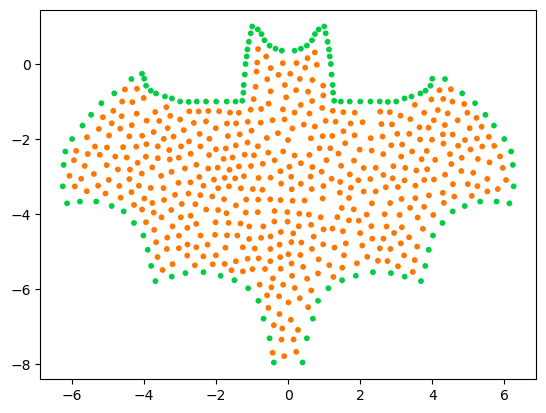

0

In [12]:
colores = ["#00cc44",  # Verde
           "#ff7700"]  # Naranja          

plt.scatter(pts_g[0]['pt_f_c'][:N   +cant_pt_cumplidos,0], pts_g[0]['pt_f_c'][:N   +cant_pt_cumplidos,1],c=np.take(colores, pts_g[0]['Color'][:N   +cant_pt_cumplidos] ),s=10)
#plt.scatter(pts_g[0]['pt_f_c'][118:187,0], pts_g[0]['pt_f_c'][118:187,1],c="black",s=10)

plt.show()
i

## Rectas Y Vectores Normales
Muestra de la formación de las rectas

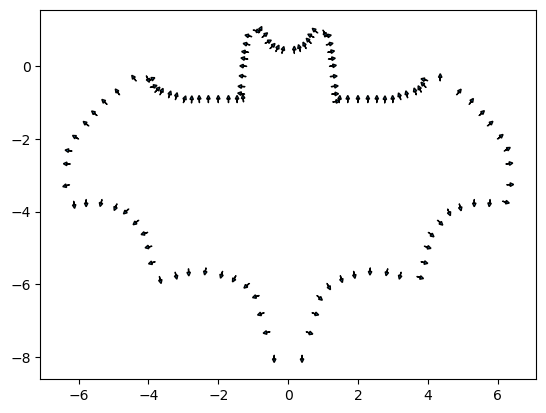

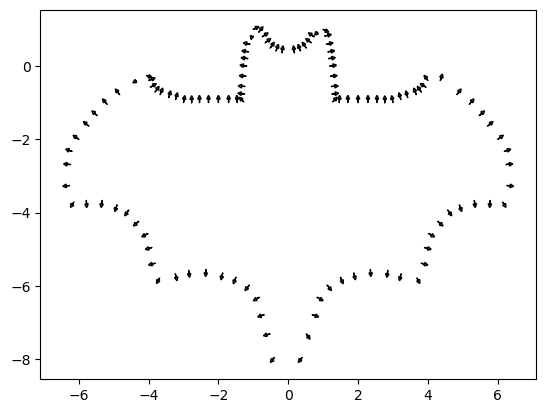

In [13]:
"""
Se calcularán los valores minimos y maximos de los puntos que tiene el poligono
después se procederá a añadirles o restarles un valor con la finalidad
de que se pueda visualizar toda la gráfica
"""
x_min = np.amin( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,0] )
x_max = np.amax( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,0] )
x_max += x_max*0.5
x_min -= x_min*0.5

y_min = np.amin( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,1] )
y_max = np.amax( pts_g[0]['pt_f_c'][:i+cant_pt_cumplidos,1] )
y_max += y_max*0.5
y_min -= y_min*0.5


#Estos son los vectores directores a las rectas normales, pero no a los puntos
vec_normal_u = np.array(vec_normal,copy=True)
vec_normal_u2 = np.array(vec_normal,copy=True)
vec_normal_u*=0.1
vec_normal_u2*=0.1


#Con esto pasaremos cada uno de los vectores directores hacia afuera de la figura
for pp in range(0,len(rectas_normales)):
    
    #Si el vector normal al hacer crecer la recta termina dentro de la figura, entonces
    #Pasaremos a movernos hacia el otro lado y listo
    x_pr,y_pr = rectas_normales[pp,2] + vec_normal_u[pp,0],rectas_normales[pp,4] + vec_normal_u[pp,1]
    
    if (sh.contains(poly,Point(x_pr,y_pr)))==True:
        vec_normal_u[pp,0] *=-1
        vec_normal_u[pp,1] *=-1
        plt.arrow(rectas_normales[pp,2],rectas_normales[pp,4],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
    else:
        plt.arrow(rectas_normales[pp,2],rectas_normales[pp,4],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
    
    
x_pr,y_pr = rectas_normales[pp,2] + vec_normal_u[pp,0],rectas_normales[pp,4] + vec_normal_u[pp,1]
    

if (sh.contains(poly,Point(x_pr,y_pr)))==True:
    vec_normal_u[pp,0] *=-1
    vec_normal_u[pp,1] *=-1    
    plt.arrow(rectas_normales[pp,3],rectas_normales[pp,5],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
else:
    plt.arrow(rectas_normales[pp,3],rectas_normales[pp,5],vec_normal_u[pp,0],vec_normal_u[pp,1],head_length = 0.1,head_width=0.1)
  

plt.show()




"""
Para calcular los vectores directores normales a los puntos, lo que se hará es:
    1. Sumar los dos vectores normales de las rectas que intersectan en el punto
    2. Se dividiran en dos sus valores y ese será el vector_director ponderado

Para eso usaremos una nueva variable:
    vec_normal_pts que en sus 2 primeros elementos guardara el punto donde inicia
    y en sus ultimos dos elementos guardará el punto en el que termina
"""
vec_normal_pts = np.zeros((N,4),np.float64)

#Esto nos ayudara a encontrar cada vector director para cada punto
#Recordemos que hay una recta menos nada más
for pp in range(0,len(rectas_normales)):
    if pp==0:
        vec_normal_pts[pp,0] = rectas_normales[pp,2]
        vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
        vec_normal_pts[pp,2] = (vec_normal_u[pp,0] + vec_normal_u[len(vec_normal_u)-1,0])/2
        vec_normal_pts[pp,3] = (vec_normal_u[pp,1] + vec_normal_u[len(vec_normal_u)-1,1])/2
        

    elif (pp != 0) :
        vec_normal_pts[pp,0] = rectas_normales[pp,2]
        vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
        vec_normal_pts[pp,2] = (vec_normal_u[pp,0] + vec_normal_u[pp-1,0])/2
        vec_normal_pts[pp,3] = (vec_normal_u[pp,1] + vec_normal_u[pp-1,1])/2
        

vec_normal_pts[pp,0] = rectas_normales[pp,2]
vec_normal_pts[pp,1] = rectas_normales[pp,4]
        
vec_normal_pts[pp,2] = (vec_normal_u[pp-1,0] + vec_normal_u[pp,0])/2
vec_normal_pts[pp,3] = (vec_normal_u[pp-1,1] + vec_normal_u[pp,1])/2
        
vec_normal_pts[N-1,0] = rectas_normales[pp,3]
vec_normal_pts[N-1,1] = rectas_normales[pp,5]
        
vec_normal_pts[N-1,2] = (vec_normal_u[pp-1,0] + vec_normal_u[pp,0])/2
vec_normal_pts[N-1,3] = (vec_normal_u[pp-1,1] + vec_normal_u[pp,1])/2
      

"""
Ahora graficaremos y aparte guardaremos las nuevas direcciones de esas normales
"""
#print(vec_normal_u)
for pp in range(0,len(rectas_normales)+1):
    #Si el vector normal al hacer crecer la recta termina dentro de la figura, entonces
    #Pasaremos a movernos hacia el otro lado y listo
    x_pr, y_pr = (vec_normal_pts[pp,0] + vec_normal_pts[pp,2]), (vec_normal_pts[pp,1] + vec_normal_pts[pp,3])
    
    if (sh.contains(poly,Point(x_pr,y_pr)))==True:
        vec_normal_pts[pp,2] *= -1
        vec_normal_pts[pp,3] *= -1
        plt.arrow(vec_normal_pts[pp,0],vec_normal_pts[pp,1],vec_normal_pts[pp,2],vec_normal_pts[pp,3],head_length = 0.1,head_width=0.1)
    else:
        plt.arrow(vec_normal_pts[pp,0],vec_normal_pts[pp,1],vec_normal_pts[pp,2],vec_normal_pts[pp,3],head_length = 0.1,head_width=0.1)

#plt.scatter(pt[0]['pt_f_c'][])       
plt.show()   



# Vectores normales con optimización

Mandaremos a llamar las funciones para encontrar los vectores normales a cada punto para el batman

C:\Users\andre\AppData\Local\Temp\ipykernel_17992\1175083055.py:247: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final = float(eig_pon[0]*0.001 + pt_c_u[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_17992\1175083055.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  y_final = float(eig_pon[1]*0.001 + pt_c_u[1])
C:\Users\andre\AppData\Local\Temp\ipykernel_17992\866679243.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
C:\Users\andre\AppData\Local\Temp\ipykernel_17992\1175083055.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final =float( eig_pon[0]*0.001 + pt_c_u[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_17992\1175083055.py:232: ComplexWarning: Casting complex values to real discards the imaginary part
  y_final =float( eig_pon[1]*0.001 + pt_c

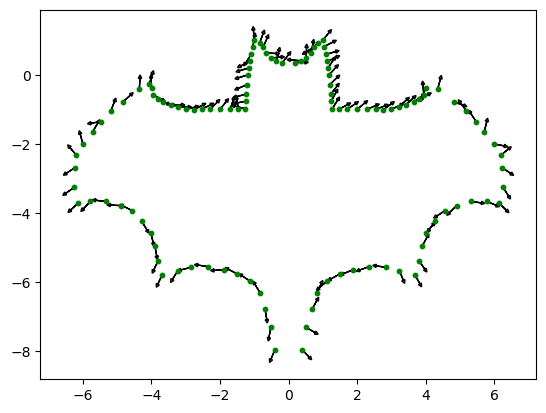

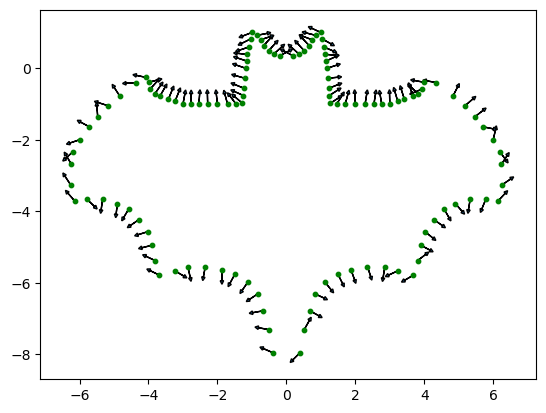

In [14]:
#Necesitamos un array que use los puntos circundantes
#y con esto los mandamos para hacer la suma de matrices
normal_optimization_vectors = np.zeros((N,2),np.float64)

#indice del punto central
i_c = 0

#Indice de los puntos cercanos
for i in range(0,N):
    normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
                                         pt_c = pts_g[0]['pt_f_c'][i],
                                         f = "Gaussian",
                                         Figura = poly, metodo=1,h=3)
    normal_optimization_vectors[i,:] *=0.3
    plt.arrow(pts_g[0]['pt_f_c'][i][0],pts_g[0]['pt_f_c'][i][1],normal_optimization_vectors[i][0],normal_optimization_vectors[i][1],head_length = 0.1,head_width=0.1)

    
plt.scatter(pts_g[0]['pt_f_c'][:N,0], pts_g[0]['pt_f_c'][:N,1],c="green",s=10)

plt.show()


#Necesitamos un array que use los puntos circundantes
#y con esto los mandamos para hacer la suma de matrices
normal_optimization_vectors = np.zeros((N,2),np.float64)

#indice del punto central
i_c = 0

#Indice de los puntos cercanos
for i in range(0,N):
    normal_optimization_vectors[i,:] = normal_metodo_optimizacion(pts_nhd = pts_g[0]['pt_f_c'][:],
                                         pt_c = pts_g[0]['pt_f_c'][i],
                                         f = "Gaussian",
                                         Figura = poly, metodo=0,h=3)
    normal_optimization_vectors[i,:] *=0.3
    plt.arrow(pts_g[0]['pt_f_c'][i][0],pts_g[0]['pt_f_c'][i][1],normal_optimization_vectors[i][0],normal_optimization_vectors[i][1],head_length = 0.1,head_width=0.1)

    
plt.scatter(pts_g[0]['pt_f_c'][:N,0], pts_g[0]['pt_f_c'][:N,1],c="green",s=10)

plt.show()

# Celda de paralelizacion de puntos vecinos

In [15]:
inicio = time.time()
#Representa la cantidad de elementos con valores de posiciones de puntos generados por el avance de frente
N_f = N+cant_pt_cumplidos

#Se obtienen los indices de los puntos circundantes de cada punto
resultados_vecindad = vecindad_paralelo_estructura(h=1,pt_g_u= pts_g[0]['pt_f_c'][:N_f,:])


#Es un arreglo con N_f arreglos de dimensiones (N_f,2)
#Que usaremos para guardar los puntos vecinos
#Se tomara que el arreglo 0 de dimensiones (N_f,2) corresponde al punto 0
#que el arreglo 1 de dimensiones (N_f,2) corresponde al punto 1 y así sucesivamente
N_f = N+cant_pt_cumplidos
pts_veci = np.zeros((N_f,N_f,2),np.float64)
pts_veci[:] = np.nan

#Creamos un arreglo de objetos que en cada uno de los elementos se le puede guardar un arreglo N-dimensional
pts_veci_objetos =  np.empty(N_f, dtype=np.object_)

j = 0
#Iterar entre los 16 cores o resultados obtenidos
for i in range(0,16):
    for jj in range(resultados_vecindad[i][0][1],resultados_vecindad[i][-1][1]+1):
        j = jj - resultados_vecindad[i][0][1]
        pts_veci[jj,:len(resultados_vecindad[i][j][0])] = pts_g[0]['pt_f_c'][resultados_vecindad[i][j][0],:]
        pts_veci_objetos[jj] =  pts_g[0]['pt_f_c'][resultados_vecindad[i][j][0],:]
print(time.time()-inicio)


#De esta manera podemos obtener todos los pts vecinos (x,y) 
pts_veci_objetos[0][:,:]

#Y así obtenemos el pt vecino 0 del punto 0
pts_veci_objetos[0][0,:]

#Y asi obtenemos el elemento x del pt vecino 0 del punto 0
pts_veci_objetos[0][0,0]

1.5141897201538086


0.684695665230042

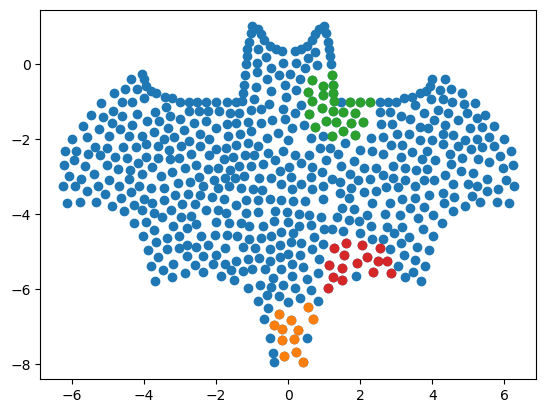

In [16]:
plt.scatter( pts_g[0]['pt_f_c'][:N_f,0], pts_g[0]['pt_f_c'][:N_f,1])
plt.scatter(pts_veci[0,:,0],pts_veci[0,:,1])
plt.scatter(pts_veci[40,:,0],pts_veci[40,:,1])

plt.scatter(pts_veci_objetos[5][:,0],  pts_veci_objetos[5][:,1])

In [17]:
pts_veci_objetos[5][:,0]

array([1.11353808, 1.49473133, 2.35241616, 2.8527323 , 1.25416116,
       1.50140544, 1.90754044, 2.49045081, 2.75581688, 1.13912746,
       1.5476033 , 2.19437886, 2.54395745, 1.2842581 , 2.05553994,
       1.59878055])

## M (matrix)

In [18]:
inicio_M = time.time()
h=1


def W_matriz_generation(pt_central,pts_vecinos_c,h,a):
    """
    El objetivo de esta funcion es generar la matriz de peso
    para cualquier punto dentro de la figura seleccionada
    la matriz debe de cambiar según cada tipo de punto, los valores de los
    renglones que se agregaran dependeran de una segunda función 
    que los calcule (esto todavia no esta implementado)
    
    Datos de entrada:
        pt_central:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        1,       2)
            Objetivo      ->   Recibir un punto (x,y) el cual se usara para calcular
                               la matriz W que corresponde a este punto
       pts_vecinos:
            Arreglo tipo numpy
            Dimensiones   ->    (renglones,columnas)
                                (        N,       2)
                                donde N representa la cantidad de puntos vecinos que
                                hay encerrados en la vecindad correspondiente al 
                                pt_central
            Objetivo      ->    Recibir un array de con los valores (x,y) de los puntos 
                                encerrados en la vecindad correspondiente al pt_central
       h:
           Variable tipo int
           Objetivo       ->    Recibir el radio de la vecindad que corresponde a cada punto
       a:
           Variable tipo float64
           Objetivo       ->    Recibir un valor que sirva para la funcion de peso gaussiana
    """
    
    #Construimos la matriz W inicializada en ceros
    #La cantidad de renglones debe de ser determinada por la cantidad
    #de puntos vecinos que se van recibir
    W = np.eye((len(pts_vecinos_c)+2,len(pts_vecinos_c)),np.float64)
    a = 1
    
    #Con esto agregamos los valores en la diagonal para el caso de Direichlet
    #Como se puede observar los ultimos dos elementos de la diagonal seran igual a 1
    for i in range(0,len(pts_vecinos_c)):
        dx = pts_vecinos_c[i,0] - pt_central[0]
        dy = pts_vecinos_c[i,1] - pt_central[1]
        
        mag2 = (dx)**2 + (dy)**2
        
        if mag2 ==0:
            print("hay algo W")
        peso = np.exp(-a*  (  mag2 /h**2 )   )
        W[i,i] = peso
    return W


def M2D_matriz_generation(pt_central,pts_vecinos_c,h):
    """
    El objetivo de la función es generar la matriz M que
    nos ayudará a solucionar la expansion de Taylor para una funcion
    alrededor del punto_central que esta dada por la ecucacion
    
    f(pt_i) = f(pt) 
    
    + \sumk_1^2 f_k(pt) (x_k,i - x_k)
    
    + \sumk,l_1^2 f_k,l(pt) (x_k,i  -  x_k)(x_l,i - x_l)
    
    """
    
    #Creamos la matriz para el caso de Dirichlet
    M = np.zeros((len(pts_vecinos_c)+2,6),np.float64)
    
    for i in range(0,len(pts_vecinos_c)):
        dx = pts_vecinos_c[i,0] - pt_central[0]
        dy = pts_vecinos_c[i,1] - pt_central[1]
        

        dxdy = dx*dy
        dx2 = (dx**2)/2
        dy2 = (dy**2)/2
        
        M[i,:] = 1,dx,dy,dx2,dxdy,dy2
    
    W =  W_matriz_generation(pt_central,pts_vecinos_c,h,1)
    return M,W



def aproximacion_estructura_dirichlet():
    """
    El objetivo de esto es hacer la primera apr
    """
    return 0

lista_M = []
lista_a_sinb = []
print(N_f)
for i in range(0,N_f):

    aux = M2D_matriz_generation(pts_g[0]['pt_f_c'][i,:],pts_veci_objetos[i][:,:2],h)
    lista_M.append( aux )
    
    #aa = np.linalg.inv(lista_M[i][0].T*lista_M[i][1]*lista_M[i][0])*(lista_M[i][0].T*lista_M[i][1])
    aa = np.dot(lista_M[i][0].T,lista_M[i][1])
    aa = np.dot(aa,lista_M[i][0])
    aa = np.linalg.inv(aa)
    bb = np.dot(lista_M[i][0].T,lista_M[i][1])
    aa = np.dot(aa,bb)
    lista_a_sinb.append(  aa  )

print("Tiempo en ejecutar M,W,a_sinb: ",time.time()-inicio_M)
print("Tiempo de ejecucion de todo el programa",time.time()-inicio_programa_tiempo)

588
Tiempo en ejecutar M,W,a_sinb:  0.1310129165649414
Tiempo de ejecucion de todo el programa 10.053905725479126


# Celdas de pruebas

Intentaremos calcular todos los puntos circundantes de cada uno de los puntos

In [19]:
#Prueba de multiplicacion de vectores y vectores transpuestos
#RC
n_vec = np.zeros((2,1))
n_vec[0] = 1
n_vec[1] = 2

n_vec*np.transpose(n_vec)

array([[1., 2.],
       [2., 4.]])

In [20]:
#Matrix 3x3
A = np.array([[0,1],
              [3,2]])

#Eigenvalores 
R_v = scipy.linalg.eigvals(A)

#Eigenvectores
R = np.linalg.eig(A)

#Eigenvectores
eig_1 = R[1][0][0],R[1][1][0]#,R[1][2][0]
#print(eig_1)
eig_2 = R[1][0][1],R[1][1][1]#,R[1][2][1]
#print(eig_2)
#eig_3 = R[1][0][2],R[1][1][2],R[1][2][2]
#print(eig_3)

#De esta manera convirmamos que sean eigenvectore
#e eigenvalores

# eig_val*eig_Vec
print(R_v[0]*np.array(eig_1))
izq_ecuacion = np.round((R_v[0]*np.array(eig_1)).real,5)
print(izq_ecuacion)
#matrix*eig_Vec
x=0
y=0
z=0
for i in range(0,2):
    x += A[0][i]*eig_1[i]
    y += A[1][i]*eig_1[i]
    #z += A[2][i]*eig_1[i]
print(R_v[0] )
print(R)
der_ecuacion = np.round(np.array([x,y]),5)


[ 0.70710678-0.j -0.70710678+0.j]
[ 0.70711 -0.70711]
(-1.0000000000000004+0j)
(array([-1.,  3.]), array([[-0.70710678, -0.31622777],
       [ 0.70710678, -0.9486833 ]]))


In [21]:
if (der_ecuacion == izq_ecuacion).all() == True:
    print("Todos iguales")

Todos iguales


## Arreglo para guardar los puntos

In [22]:
#Es un arreglo con N arreglos de dimensiones (N,2)
arra = np.zeros((N,N,2),np.float64)

#Le ponenmos que no tienen valor todos los puntos
arra[:] = np.nan

arra[1,:1]= 1
arra[0,:]=2

arra[0,:][0].T()

TypeError: 'numpy.ndarray' object is not callable